In [37]:
import os.path
import random
import time
from time import sleep
import networkx as nx
import numpy as np

import osmnx as ox
import pandas as pd
from tqdm.notebook import trange, tqdm
import pickle
import os
import itertools
import folium
from matplotlib import pyplot as plt
from multiprocessing import Pool
import kmapper as km
from kmapper.jupyter import display

In [38]:
def upper_path(path:list, g:nx.Graph)->list:
    p = []
    for i in range(len(path)):
        point = path[i]
        c = g.nodes()[point]['cluster']
        if len(p) == 0:
            p.append(c)
        elif c!=p[-1]:
            p.append(c)
    return p

In [39]:
# Statistic for all-pair-paths between points of two clusters
def get_statistic_per_point(graph: nx.Graph, c_from: int, c_to: int, _cls2hubs: dict[int:set[int]], log=False):
    nodes_from = _cls2hubs[c_from]
    nodes_to = _cls2hubs[c_to]
    statistic = {}
    iter = itertools.product(nodes_from, nodes_to)
    generator = tqdm(iter, desc='find statistic', total=len(nodes_to) * len(nodes_from)) if log else iter
    for f,t in generator:
        p = nx.single_source_dijkstra(graph, f, t, weight='length')
        cls = upper_path(p[1],graph)
        cls = tuple(cls)
        if cls not in statistic:
            statistic[cls] = 0
        statistic[cls] += 1
    return statistic

In [40]:
# cluster to neighboring clusters
def get_cls2n(graph: nx.Graph) -> dict[int: set[int]]:
    _cls2n = {}
    for u, du in graph.nodes(data=True):
        for v in graph[u]:
            dv = graph.nodes()[v]
            if dv['cluster'] == du['cluster']:
                continue
            c1 = dv['cluster']
            c2 = du['cluster']
            if not (c1 in _cls2n):
                _cls2n[c1] = set()
            if not (c2 in _cls2n):
                _cls2n[c2] = set()
            _cls2n[c1].add(c2)
            _cls2n[c2].add(c1)
    return _cls2n


# cluster then yts point that are connected with neighboring clusters
def get_cls2hubs(graph: nx.Graph) -> dict[int: set[int]]:
    _cls2hubs = {}
    for u, du in graph.nodes(data=True):
        for v in graph[u]:
            dv = graph.nodes()[v]
            c1 = du['cluster']
            c2 = dv['cluster']
            if c1 == c2:
                continue
            if not (c1 in _cls2hubs):
                _cls2hubs[c1] = set()
            if not (c2 in _cls2hubs):
                _cls2hubs[c2] = set()
            _cls2hubs[c1].add(u)
            _cls2hubs[c2].add(v)
    return _cls2hubs

# функция для параллельного вычисления матрицы смежности
def do_ad_mat(data):
    g , points, cls2n , cls2hubs, worker = data.values()
    ad_matrix={}
    sleep(worker/10)
    print(f'start: {worker}')
    for i in tqdm(points, total=len(points), position=worker, desc=f'build ad_matrix, work:{worker}'):
        ad_matrix[i] = {}
        for j in set(cls2n[i]).union({i}):
            data = get_statistic_per_point(g, i, j, cls2hubs, False)
            cls0to1 = set()
            for k, v in data.items():
                for kk in k:
                    cls0to1.add(kk)
            ad_matrix[i][j] = cls0to1
    return ad_matrix


# adjacency matrix. it contains clusters that intersect with paths between two clusters
def get_ad_matrix(
        graph: nx.Graph,
        communities: list[set[int]],
        cls2hubs,
        cls2n,
        WORKERS = 4
) -> dict[int: dict[int:set[int]]]:
    ad_matrix = {}
    
    data = [{
        'g': graph,
        'points': [i for i in range(worker, len(communities), WORKERS)],
        'cls2n': cls2n,
        'cls2hubs': cls2hubs,
        'worker': worker
    } for worker in range(WORKERS)]
    with Pool(WORKERS) as p:
        res = p.map(do_ad_mat, data)
    for r in res:
        for i in r:
            if i not in ad_matrix:
                ad_matrix[i] = {}
            for j in r[i]:
                ad_matrix[i][j] = r[i][j]
    return ad_matrix

def get_r(_g:nx.Graph, u:int)->float:
    nodes = len(_g.nodes())
    summ_d = 0
    paths = nx.shortest_path_length(_g, u, weight='length')
    for _,l in paths.items():
        summ_d+=l
    return summ_d/nodes

def get_min_dst(_g:nx.Graph, c1:int, c2:int)->float:
    m = float('inf')
    for u, du in _g.nodes(data=True):
        if du['cluster']!=c1:
            continue
        for v,d in _g[u].items():
            dv = _g.nodes()[v]
            if dv['cluster']!=c2:
                continue
            l = d['length']
            if l <m:
                m=l
    return m
# build_center_graph
def build_center_graph(
        graph: nx.Graph,
        communities: list[set[int]],
        adjacency: dict[int:dict[int, set[int]]],
        cls2n: dict[int: set[int]]
) -> tuple[nx.Graph, dict[int, int]]:
    x_graph = nx.Graph()
    cls2c = {}
    for cls, _ in tqdm(enumerate(communities), total=len(communities), desc='find centroids'):
        gc = extract_cluster_list_subgraph(graph, [cls], communities)
        min_node = nx.barycenter(gc, weight='length')[0]
        du = graph.nodes()[min_node]
        x_graph.add_node(graph.nodes()[min_node]['cluster'], **du)
        cls2c[graph.nodes()[min_node]['cluster']] = min_node

    if len(x_graph.nodes) == 1:
        return x_graph, cls2c
    
    for u in tqdm(x_graph.nodes(), desc = 'find edges'):
        for v in cls2n[u]:
            g = extract_cluster_list_subgraph(graph, adjacency[u][v], communities)
            l = nx.single_source_dijkstra(g, source=cls2c[u], target=cls2c[v], weight='length')[0]
            # ll = get_min_dst(graph, u,v) 
            # ll_u = get_r(extract_cluster_list_subgraph(graph, [u], communities), cls2c[u])
            # ll_v = get_r(extract_cluster_list_subgraph(graph, [v], communities), cls2c[v])
            # print(l, ll, ll_u,ll_v, ll+ll_u+ll_v)
            x_graph.add_edge(u, v, length=l)
    return x_graph, cls2c


In [41]:
#load graph
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        if u == v:
            continue
        da=H.nodes()[u]
        db=H.nodes()[v]
        # H.add_edge(u, v, length=((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000)
        H.add_edge(u, v, length=d['length'])
    del city_id, gdf, polygon_boundary, graph, G
    return H

#extract subgraph by clusters
def extract_cluster_list_subgraph(graph: nx.Graph, cluster_number: list[int] | set[int], communities=None) -> nx.Graph:
    if communities:
        nodes_to_keep = [u for c in cluster_number for u in communities[c]]
    else:
        nodes_to_keep = [node for node, data in graph.nodes(data=True) if data['cluster'] in cluster_number]
    return graph.subgraph(nodes_to_keep)



In [42]:
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, BisectingKMeans


#resolve_communities
def resolve_communities(H: nx.Graph, **params) -> list[set[int]]:
    communities = nx.community.louvain_communities(H,
                                                   seed=1534,
                                                   weight='length',
                                                   resolution=params['r'])
    cls = []
    for i, c in enumerate(communities):
        for n in nx.connected_components(H.subgraph(c)):
            cls.append(n)
    for i, ids in enumerate(cls):
        for j in ids:
            H.nodes()[j]['cluster'] = i
    return cls

def resolve_by_hdbscan(H: nx.Graph):
    # paths = dict(tqdm(nx.all_pairs_dijkstra_path_length(H, weight='length'), total=(len(H.nodes()))))
    def f(a,b):
        u = int(a[2])
        v = int(b[2])
        # return paths[u][v]
        if (u,v) in H.edges() or (v,u) in H.edges():
            return H.edges()[(u,v)]['length']
        return float('inf')
        # return nx.single_source_dijkstra(g, u,v,weight='length')[0]
    scan = HDBSCAN(metric=f, min_samples=1, max_cluster_size=30,n_jobs=-1,store_centers='medoid')
    x = np.array([[d['x'], d['y'], u] for u, d in g.nodes(data=True)])
    y = scan.fit_predict(x)
    communities = {}
    for i, u in enumerate(g.nodes):
        cls = y[i]
        if cls not in communities:
            communities[cls] = set()
        communities[cls].add(u)
    communities = [communities[cls] for cls in communities]
    cls = []
    for i, c in enumerate(communities):
        for n in nx.connected_components(g.subgraph(c)):
            cls.append(n)
    for i, ids in enumerate(cls):
        for j in ids:
            H.nodes()[j]['cluster'] = i
    del scan
    return cls

def resolve_by_mapper(H: nx.Graph):
    id2node = {i:u for i,u in enumerate(H.nodes())}
    x = np.array([[d['x'], d['y'], u] for u, d in H.nodes(data=True)])
    m = km.KeplerMapper()
    pd = m.fit_transform(x)
    gg = m.map(pd, x, clusterer=HDBSCAN(metric='cosine'))
    communities = []
    for i, u in gg['nodes'].items():
        nodes  = {id2node[k] for k in u}
        communities.append(nodes)
    print(len(communities))
    cls = []
    for i, c in enumerate(communities):
        # print(c)
        for n in nx.connected_components(g.subgraph(c)):
            cls.append(n)
    for i, ids in enumerate(cls):
        for j in ids:
            H.nodes()[j]['cluster'] = i
    return cls
    

In [43]:
# примеры id есть в test_city.py
id_graph = 'R2555133'
path = f'../data/graphs/{id_graph}.pickle'
if os.path.exists(path):
    with open(path, 'rb') as fp:
        g : nx.Graph = pickle.load(fp)
        fp.close()
else:
    g = get_graph(id_graph)
    with open(path, 'wb') as fp:
        pickle.dump(g, fp)
        fp.close()
assert g is not None
len(g.nodes()), len(g.edges())

(17921, 27013)

In [44]:
# оптимальное количество кластеров из статьи
def get_opt_cluster_count(nodes:int)-> int:
    alpha = 8.09 * (nodes ** (-0.48)) * (1 - 19.4 / (4.8 * np.log(nodes) + 8.8)) * nodes
    return int(alpha) 

In [45]:
get_opt_cluster_count(len(g.nodes()))

859

In [46]:
# cms = resolve_communities(g, r=1000)
# cms = resolve_by_hdbscan(g)
cms = resolve_by_mapper(g)
print(len(cms))

38
5528


In [47]:
cls2n = get_cls2n(g)
cls2hubs = get_cls2hubs(g)

KeyError: 'cluster'

In [31]:
l = range(len(cms))
iter = itertools.product(l,l)
one = 0
other = 0
for n,(i,j) in tqdm(enumerate(iter), total = len(cms)**2):
    stat = get_statistic_per_point(g, i, j, cls2hubs, False)
    total = sum([x[1] for x in stat.items()])
    stat = list(stat.items())
    stat.sort(key=lambda x:-x[1])
    stat=dict(stat)
    if (len(stat)) == 1:
        one+=1
    else:
        other+=1
    if n > 200:
        break
    # print('stat:')
    # for u,d in stat.items():
    #     print(f'{d/total:.2f}')
print(one, other)

0it [00:00, ?it/s]

0 0


In [ ]:
print(one, other)

In [49]:
ad_mat = get_ad_matrix(g, cms, cls2hubs, cls2n, WORKERS=20)

NameError: name 'cls2hubs' is not defined

In [121]:
g1, cls2c = build_center_graph(g, cms, ad_mat, cls2n)

find centroids:   0%|          | 0/4601 [00:00<?, ?it/s]

find edges:   0%|          | 0/4601 [00:00<?, ?it/s]

In [ ]:
radius = []
for i, nodes in enumerate(tqdm(cms)):
    r = nx.radius(g.subgraph(nodes), weight='length')
    radius.append(r)

In [77]:
a = np.zeros((len(cms), len(cms)))

In [90]:
for c1,c2 in tqdm([(i,j)for i in range(len(cms)) for j in range(i, len(cms))]):
    center1, center2 = cls2c[c1], cls2c[c2]
    path = tuple(upper_path(nx.shortest_path(g, center1, center2, weight='length'), g))
    stat = get_statistic_per_point(g,c1,c2,cms, False)
    stat = list(stat.items())
    stat.sort(key=lambda x: -x[1])
    stat = dict(stat)
    total = 0
    val = 0
    for k, v in stat.items():
        total+=v
        if k == path:
            val = v
    a[c1,c2] = val/total
    a[c2,c1] = val/total

  0%|          | 0/4278 [00:00<?, ?it/s]

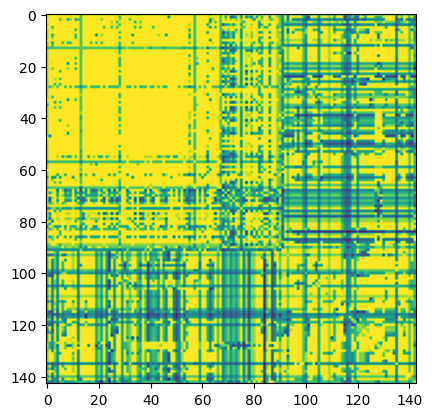

In [91]:
# a = (a>0)*100
plt.imshow(a)

In [84]:
H = nx.adjacency_matrix(g1).toarray()

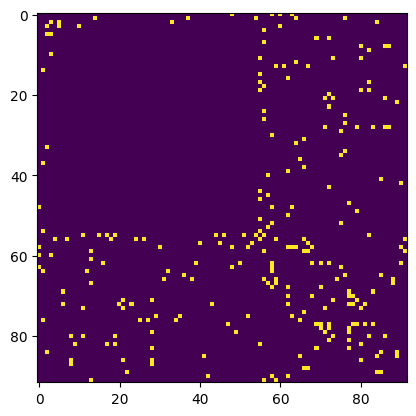

In [92]:
plt.imshow(nx.adjacency_matrix(g1).toarray())

In [93]:
from scipy.ndimage import convolve
aa = convolve(nx.adjacency_matrix(g1).toarray(), a)

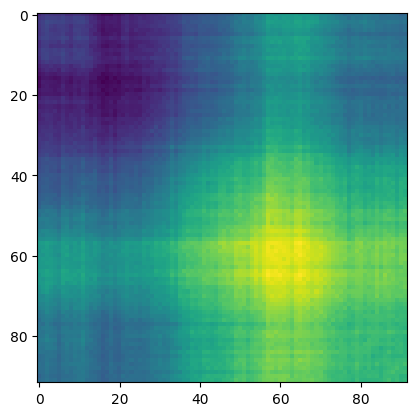

In [94]:
plt.imshow(aa)

In [ ]:
c1 = 0
c2 = 234

center1, center2 = cls2c[c1], cls2c[c2]
path = tuple(upper_path(nx.shortest_path(g, center1, center2, weight='length'), g))
stat = get_statistic_per_point(g,c1,c2,cms, True)
stat = list(stat.items())
stat.sort(key=lambda x: -x[1])
stat = dict(stat)
for k, v in stat.items():
    if k == path:
        print(v, 'eq')
    else:
        print(v)

In [95]:
def build_geodetic(g_centers, ad_mat):
    paths = dict(tqdm(nx.all_pairs_dijkstra_path(g_centers, weight='length'), total=(len(g_centers.nodes()))))
    paths_len = dict(tqdm(nx.all_pairs_dijkstra_path_length(g_centers, weight='length'), total=(len(g_centers.nodes()))))
    nodes = list(g_centers.nodes())
    paths_t = [(nodes[i],nodes[j],paths_len[nodes[i]][nodes[j]],paths[nodes[i]][nodes[j]]) for i in range(len(nodes)) for j in range(i+1, len(nodes))]
    del paths_len
    del paths
    paths_t.sort(key=lambda x:-len(x[3]))
    data_graph = {u : {} for u in nodes }
    for u in nodes:
        for v in nodes:
            data_graph[u][v]=None
            
    for u,v,length,path in tqdm(paths_t):
        gg = None
        num_nodes = 0
        for i in range(len(path) - 1):
            c1 = path[i]
            c2 = path[i+1]
            for cc in ad_mat[c1][c2]:
                num_nodes += len(cms[cc])
        cls = set()
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            cu = g.nodes()[cls2c[u]]['cluster']
            cv = g.nodes()[cls2c[v]]['cluster']
            for c in ad_mat[cu][cv]:
                cls.add(c)
            cls.add(cu)
            cls.add(cv)
        new_num_nodes = sum([len(cms[c]) for c in cls])
        for p1 in path:
            for p2 in path:
                gg0 = data_graph[p1][p2]
                if gg0 is None:
                    if gg is None:
                        gg = extract_cluster_list_subgraph(g, path, cms)
                    data_graph[p1][p2] = gg
                    data_graph[p2][p1] = gg
                    
                    # data_graph[p1][p2] = cls
                    # data_graph[p2][p1] = cls
                    continue
                # если новый кусок существенно меньше старого
                # if num_nodes/10 > new_num_nodes:
                #     if gg is None:
                #         gg = extract_cluster_list_subgraph(g, path, cms)
                #     data_graph[p1][p2] = gg
                #     data_graph[p2][p1] = gg
    return data_graph

In [ ]:
# del data_graph

In [ ]:
data_graph = build_geodetic(g1,ad_mat)

In [96]:
# find path between two points
def find_path_length_h(
        g0: nx.Graph,
        g1: nx.Graph,
        adjacency: dict[int, dict[int:set[int]]],
        cms: list[set[int]] | tuple[set[int]],
        cls2c: dict[int:int],
        from_node: int,
        to_node: int,
        cls2n: dict[int, set[int]]) -> float:
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']

    cls = {to_cluster, from_cluster}

    def h(a, b):
        da = g0.nodes()[cls2c[a]]
        db = g0.nodes()[to_node]
        return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 * 0.56

    # path = nx.single_source_dijkstra(g1, from_cluster, to_cluster, weight='length')[1]
    path = nx.astar_path(g1, from_cluster, to_cluster, weight='length', heuristic=h)
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        cu = g0.nodes()[cls2c[u]]['cluster']
        cv = g0.nodes()[cls2c[v]]['cluster']
        # for c in adjacency[cu][cv]:
        #     cls.add(c)
        cls.add(cu)
        cls.add(cv)

    # for c1 in cls2n[to_cluster].union({to_cluster}):
    #     for c2 in cls2n[from_cluster].union({from_cluster}):
    #         path = nx.astar_path(g1, c1, c2, h, weight='length')
    #         for i in range(len(path) - 1):
    #             u = path[i]
    #             v = path[i + 1]
    #             cu = g0.nodes()[cls2c[u]]['cluster']
    #             cv = g0.nodes()[cls2c[v]]['cluster']
    #             # for c in adjacency[cu][cv]:
    #             #     cls.add(c)
    #             cls.add(cu)
    #             cls.add(cv)
    def h(a, b):
        da = g0.nodes()[a]
        db = g0.nodes()[b]
        return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 * 0.56

    g = extract_cluster_list_subgraph(g0, cls, cms)
    # return nx.astar_path_length(g, from_node, to_node, weight='length', heuristic=h), []
    return nx.single_source_dijkstra(g, from_node, to_node, weight='length')


In [97]:
# find path between two points with few layer 
# метод не показал хороших реальтатов, ошибка растет примерно в 5 раз, ускорение не меняется
def find_path_length_h_few_layer(
        g0: nx.Graph,
        g1: nx.Graph,
        g2: nx.Graph,
        cms: list[set[int]] | tuple[set[int]],
        cms_1: list[set[int]] | tuple[set[int]],
        cls2c: dict[int:int],
        cls2c_1: dict[int:int],
        from_node: int,
        to_node: int,
        ) -> float:
    
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']

    from_cluster1 = g1.nodes()[from_cluster]['cluster']
    to_cluster1 = g1.nodes()[to_cluster]['cluster']

    cls = {to_cluster1, from_cluster1}
    path = nx.single_source_dijkstra(g2, from_cluster1, to_cluster1, weight='length')[1]
    
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        cu = g1.nodes()[cls2c_1[u]]['cluster']
        cv = g1.nodes()[cls2c_1[v]]['cluster']
        cls.add(cu)
        cls.add(cv)
    g = extract_cluster_list_subgraph(g1, cls, cms_1)
    
    path = nx.single_source_dijkstra(g, from_cluster, to_cluster, weight='length')[1]
    cls = {to_cluster, from_cluster}
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        cu = g0.nodes()[cls2c[u]]['cluster']
        cv = g0.nodes()[cls2c[v]]['cluster']
        cls.add(cu)
        cls.add(cv)

    g = extract_cluster_list_subgraph(g0, cls, cms)
    return nx.single_source_dijkstra(g, from_node, to_node, weight='length')


In [98]:
# find path between two points
def find_path_length_h_with_graphs(
        g0: nx.Graph,
        from_node: int,
        to_node: int) -> float:
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']
    
    def h(a, b):
        da = g0.nodes()[a]
        db = g0.nodes()[b]
        return ((da['x'] - db['x']) ** 2 + (da['y'] - db ['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 * 0.56

    # return nx.astar_path_length(data_graph[from_cluster][to_cluster], from_node, to_node, weight='length', heuristic=h), []
    
    # g = extract_cluster_list_subgraph(g0,data_graph[from_cluster][to_cluster], cms)
    g = data_graph[from_cluster][to_cluster]
    return nx.single_source_dijkstra(g, from_node, to_node, weight='length')


In [ ]:
# пример второго слоя в кластеризации
# from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, BisectingKMeans
# def f(a,b):
#     u = int(a[2])
#     v = int(b[2])
#     if (u,v) in g1.edges() or (v,u) in g1.edges():
#         return g1.edges()[(u,v)]['length']
#     return float('inf')
#     # return nx.single_source_dijkstra(g, u,v,weight='length')[0]
# scan = HDBSCAN(metric=f, min_samples=1)
# x = np.array([[d['x'], d['y'], u] for u, d in g1.nodes(data=True)])
# y = scan.fit_predict(x)
# communities = {}
# for i, u in enumerate(g1.nodes):
#     cls = y[i]
#     if cls not in communities:
#         communities[cls] = set()
#     communities[cls].add(u)
# communities = [communities[cls] for cls in communities]
# cls = []
# for i, c in enumerate(communities):
#     for n in nx.connected_components(g1.subgraph(c)):
#         cls.append(n)
# for i, ids in enumerate(cls):
#     for j in ids:
#         g1.nodes()[j]['cluster'] = i
# cms_1 = cls
# len(cms_1)
# cls2n_1 = get_cls2n(g1)
# cls2hubs_1 = get_cls2hubs(g1)
# ad_mat_1 = get_ad_matrix(g1, cms_1, cls2hubs_1, cls2n_1, WORKERS=20)
# g2, cls2c_1 = build_center_graph(g1, cms_1, ad_mat_1, cls2n_1)

In [ ]:
def get_node_for_initial_graph_v2(graph: nx.Graph):
    nodes = list(graph.nodes())
    f, t = random.choice(nodes), random.choice(nodes)
    while f == t:
        f, t = random.choice(nodes), random.choice(nodes)
    return f, t

# if os.path.exists('../data/points.pkl'):
#     with open('../data/points.pkl', 'rb') as fp:
#         points = pickle.load(fp)
#         fp.close()
# else:
points = [get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]
# with open('../data/points.pkl', 'wb') as fp:
#     pickle.dump(points, fp)
#     fp.close()

check a-star


In [ ]:
h_coef = 1
def h_func(a, b):
    da = g.nodes()[a]
    db = g.nodes()[b]
    return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000

for e in g.edges():
    u,v = e
    du,dv=g.nodes()[u], g.nodes()[v]
    w = g.edges()[e]['length']
    h = h_func(u,v)
    h_coef = min(h_coef, w/h)
h_coef

In [ ]:
h_coef_upper = 1
def h_func(a, b):
    da = g1.nodes()[a]
    db = g1.nodes()[b]
    return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000

for e in g1.edges():
    u,v = e
    du,dv=g1.nodes()[u], g1.nodes()[v]
    w = g1.edges()[e]['length']
    h = h_func(u,v)
    h_coef_upper = min(h_coef_upper, w/h)
h_coef_upper

In [ ]:

def h(a, b):
    da = g.nodes()[a]
    db = g.nodes()[b]
    return ((da['x'] - db['x']) ** 2 + (da['y'] - db['y']) ** 2) ** 0.5 / 360 * 2 * np.pi * 6371.01 * 1000 *h_coef

def do_calc(data):
    pps, i = data

    stat = {}
    stat['l'] = []
    stat['h_l'] = []
    stat['time_l'] = []
    stat['time_h'] = []

    stat['delta'] = []
    sleep(i/10)
    print('start', i)
    for p1, p2 in tqdm(pps, desc='find paths', position=i):
        if (p1, p2) in stat:
            continue
        num_iter = 2
        length, p = None, None
        start = time.time()
        for _ in range(num_iter):
            length, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = time.time() - start
        h_l, h_p = None, None
        start = time.time()
        for _ in range(num_iter):
            h_l = nx.astar_path_length(g,  p1, p2, h,weight='length')
        time_h = time.time() - start
        delta = (h_l - length) / length * 100
        stat['l'].append(length)
        stat['h_l'].append(h_l)
        stat['delta'].append(delta)
        stat['time_l'].append(time_l)
        stat['time_h'].append(time_h)

    return stat
astar = True
if astar:
    WORKER = 4
    data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
    with Pool(WORKER) as p:
        res = p.map(do_calc, data)
    stat = {}
    for l in res:
        for d in l:
            if d not in stat:
                stat[d] = []
            stat[d].extend(l[d])
    print('err_mean:', np.mean(stat['delta']))
    print('err_min:', np.min(stat['delta']))
    print('err_max:', np.max(stat['delta']))
    print(np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])))

In [122]:
import time


def do_calc(data):
    pps, i = data

    stat = {}
    stat['l'] = []
    stat['h_l'] = []
    stat['p'] = []
    stat['h_p'] = []
    stat['time_l'] = []
    stat['time_h'] = []

    stat['delta'] = []
    sleep(i/10)
    print('start', i)
    for p1, p2 in tqdm(pps, desc='find paths', position=i):
        if (p1, p2) in stat:
            continue
        num_iter = 2
        l, p = None, None
        start = time.time()
        for i in range(num_iter):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = time.time() - start
        h_l, h_p = None, None
        start = time.time()
        for _ in range(num_iter):
            # h_l, h_p  = find_path_length_k_paths(g, g1, ad_mat,cms, cls2c, p1, p2, cls2n)
            h_l, h_p = find_path_length_h(g, g1, ad_mat,cms, cls2c, p1, p2, cls2n)
            # h_l, h_p = find_path_length_h(g, p1, p2)
            # h_l, h_p = find_path_length_h_with_graphs(g,p1, p2)
        
        time_h = time.time() - start
        
        delta = (h_l - l) / l * 100
        stat['l'].append(l)
        stat['h_l'].append(h_l)
        stat['p'].append(p)
        stat['h_p'].append(h_p)
        stat['delta'].append(delta)
        stat['time_l'].append(time_l)
        stat['time_h'].append(time_h)

    return stat

WORKER = 4
data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    res = p.map(do_calc, data)
stat = {}
for l in res:
    for d in l:
        if d not in stat:
            stat[d] = []
        stat[d].extend(l[d])

print('err_mean:', np.mean(stat['delta']))
print('err_min:', np.min(stat['delta']))
print('err_max:', np.max(stat['delta']))
print(np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])))

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

err_mean: 10.938026738998081
err_min: 0.0
err_max: 95.5369242264973
9.229879114402854


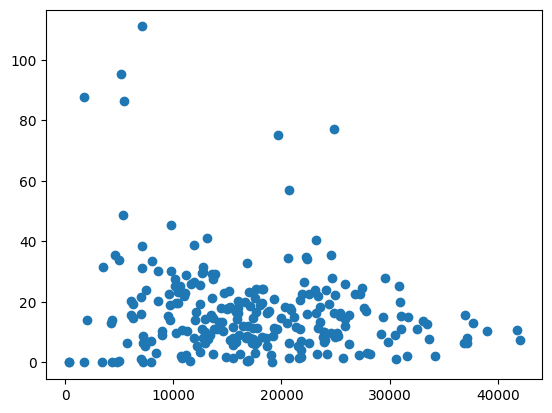

In [112]:
plt.scatter(l['l'],np.array(l['delta']))

In [ ]:
from matplotlib import pyplot as plt

data = stat['delta']
data = np.array(data)
# data = data[data<10]
x = data

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set(xlabel='err, %', ylabel='count')
# ax[0].hist(x,bins=40, density=True, color='grey')

hist, bins = np.histogram(x, bins=100)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1] - bins[0]))
# ax.set_   
# print(bins)
# ax[0].set_title('normed=True')
ax.set_title('hist = hist / hist.sum()')

In [ ]:
from matplotlib import pyplot as plt

df = pd.DataFrame.from_dict(stat)
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)

df.hist(column=['delta'], density=1, bins=10, ax=axs, xlabelsize=20, ylabelsize=20)

In [ ]:
df

In [ ]:
from matplotlib import pyplot as plt

f = df.get(['delta', 'l', 'h_l'])
# plt.scatter(f['l'], f['delta'])
# plt.scatter(f['h_l'], f['delta'])

x = np.linspace(min(f['l']), max(f['l']), 100)
plt.plot(x, x, c='red')
plt.scatter(f['l'], f['h_l'])

In [ ]:
delta = f['h_l'] - f['l']
print(f"""
max: {np.max(delta):.2f}
mean: {np.mean(delta):.2f} +- {np.std(delta):.2f}
""")

In [ ]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(f['l'], f['h_l'])
# coefficient_of_dermination = r2_score(f['l'], f['h_l'])
print(f"""
r: {r_value}
p: {p_value}
""")

In [ ]:
from scipy.optimize import curve_fit


def line(x, a, b):
    return a * x + b


popt = curve_fit(line, f['l'], f['h_l'])
print(f"""
a: {popt[0][0]:.4f} +- {np.sqrt(popt[1][0, 0]):.8f}
b: {popt[0][1]:.4f} +- {np.sqrt(popt[1][1, 1]):.8f}
""")

In [ ]:
def get_color_list(l: int):
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i / l) for i in range(l)]
    hex_colors = ['#' + ''.join([f'{int(c * 255):02x}' for c in color[:3]]) \
                  for color in colors]
    return hex_colors


def draw_on_map(_g: nx.Graph,
                communities: tuple = None,
                m: folium.Map = None,
                node_colors: list | str = None,
                edge_colors: str = 'black') -> folium.Map:
    if communities is None:
        communities = [{u} for u in _g.nodes()]
    if node_colors is None:
        node_colors = get_color_list(len(communities))

    if m is None:
        for u, d in _g.nodes(data=True):
            u_x, u_y = d['x'], d['y']
            break
        m = folium.Map(location=[u_y, u_x], zoom_start=10)  # Координаты города
    for i, community in enumerate(communities):
            
        for node in community:
            if node not in _g.nodes():
                continue
            node_data = _g.nodes[node]
            popup_text = f"Кластер: {i}, \n" + f"номер: {node}"
            folium.CircleMarker(
                location=(node_data['y'], node_data['x']),
                radius=4,
                color=node_colors[i] if isinstance(node_colors, list) else node_colors,
                fill=True,
                fill_color=node_colors[i] if isinstance(node_colors, list) is list else node_colors,
                fill_opacity=0.7,
                popup=popup_text
            ).add_to(m)
    if not (edge_colors is None):
        for u, v, data in _g.edges(data=True):
            u_x, u_y = _g.nodes()[u]['x'], _g.nodes()[u]['y']
            v_x, v_y = _g.nodes()[v]['x'], _g.nodes()[v]['y']
            folium.PolyLine([(u_y, u_x), (v_y, v_x)], color=edge_colors, weight=1).add_to(m)
    return m

In [ ]:
# рисовалка для osm
# m = draw_on_map(g, node_colors='red')
# m.save('msk_without_2_deg.html')
# m.show_in_browser()

In [ ]:
# рисует топ по ошибкам
sorted = np.argsort(stat['delta'])
index = -1
while stat['delta'][sorted[index]] > 5:
    print(stat['delta'][sorted[index]])
    max_index = np.argsort(stat['delta'])[index]
    index -= 1
    correct_path = g.subgraph(stat['p'][max_index])
    h_path = g.subgraph(stat['h_p'][max_index])
    # continue
    clusters = set()
    for i in range(len(correct_path) - 1):
        c1 = g.nodes()[stat['p'][max_index][i]]['cluster']
        c2 = g.nodes()[stat['p'][max_index][i + 1]]['cluster']
        clusters.add(c1)
        if c1 != c2:
            clusters = clusters.union(ad_mat[c1][c2])
    for i in range(len(h_path) - 1):
        c1 = g.nodes()[stat['h_p'][max_index][i]]['cluster']
        c2 = g.nodes()[stat['h_p'][max_index][i + 1]]['cluster']
        clusters.add(c1)
        if c1 != c2:
            clusters = clusters.union(ad_mat[c1][c2])

    sub_graph = nx.Graph(extract_cluster_list_subgraph(g, clusters, cms))
    cls = {}
    counter = 0
    for c in clusters:
        cls[c] = counter
        counter += 1
    for u, d in sub_graph.nodes(data=True):
        d['cluster'] = cls[d['cluster']]

    pos_sub_graph = {u: (d['x'], d['y']) for u, d in sub_graph.nodes(data=True)}
    pos_correct_path = {u: (d['x'], d['y']) for u, d in correct_path.nodes(data=True)}
    pos_h_path = {u: (d['x'], d['y']) for u, d in h_path.nodes(data=True)}
    pos_centers = {u: (d['x'], d['y']) for u, d in g1.nodes(data=True)}
    # pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}

    cmap = plt.get_cmap('plasma')
    colors_sub_graph = [cmap(d['cluster'] / len(clusters)) for u, d in sub_graph.nodes(data=True)]
    colors_sub_centers = [cmap(d['cluster'] / len(clusters)) for u, d in g1.nodes(data=True)]

    fig, axs = plt.subplots(1, 1)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    e = stat['delta'][sorted[index + 1]]
    axs.set_title(f'err: {e:.2f}')
    label_dict = {u: d['cluster'] for u, d in sub_graph.nodes(data=True)}

    nx.draw(sub_graph, ax=axs, node_size=50, pos=pos_sub_graph, alpha=0.5, node_color=colors_sub_graph)
    # nx.draw(g1, ax=axs, node_size=50, pos=pos_centers, node_color='white')
    nx.draw(correct_path, ax=axs, node_size=50, pos=pos_correct_path, node_color='red')
    nx.draw(h_path, ax=axs, node_size=50, pos=pos_h_path, node_color='green')
    pos_sub_graph = {u: (x + 0.0005, y) for u, (x, y) in pos_sub_graph.items()}
    # nx.draw_networkx_labels(sub_graph, pos_sub_graph, labels=label_dict, font_size=15)
    # nx.draw(H, ax=axs,node_size = 50, pos=pos_H, node_color = 'red', edge_color = 'green')
    plt.show()